In [10]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from dotenv import load_dotenv

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel
from cities.utils.data_loader import select_from_data, ZoningDataset

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_model import TractsModel
from cities.utils.data_loader import select_from_sql


root = find_repo_root()

In [2]:
census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/census_tracts_dataset.pt"
)


ct_dataset_read = torch.load(census_tracts_data_path)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
old_data = next(iter(ct_loader))

print(old_data['categorical'].keys())
print(old_data['continuous'].keys())

dict_keys(['year_original', 'year', 'census_tract'])
dict_keys(['housing_units', 'housing_units_original', 'income', 'income_original', 'mean_distance', 'mean_distance_original', 'mean_limit', 'mean_limit_original', 'median_distance', 'median_distance_original', 'median_value', 'median_value_original', 'segregation', 'segregation_original', 'total_value', 'total_value_original', 'white', 'white_original'])


In [17]:
load_dotenv()
load_dotenv(os.path.expanduser("~/.env_pw"))

DB_USERNAME = os.getenv("DB_USERNAME")
HOST = os.getenv("HOST")
DATABASE = os.getenv("DATABASE")
PASSWORD = os.getenv("PASSWORD")

print(DB_USERNAME, HOST, DATABASE, PASSWORD)



new_kwargs = {
    "categorical": ["year", "census_tract"],
    "continuous": {
        "housing_units",
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

postgres 34.123.100.76 cities VA.TlSR#Z%mu**Q9


In [18]:
load_start = time.time()
with sqlalchemy.create_engine(
    f"postgresql://{DB_USERNAME}:{PASSWORD}@{HOST}/{DATABASE}"
).connect() as conn:
    subset = select_from_sql(
        "select * from dev.tracts_model__census_tracts order by census_tract, year",
        conn,
        new_kwargs,
    )
load_end = time.time()
print(f"Data loaded in {load_end - load_start} seconds")

Data loaded in 33.775843381881714 seconds


In [23]:
print(subset['continuous'].keys())

print(subset['continuous']['downtown_overlap'].unique())

print(subset['continuous']['university_overlap'].unique())


dict_keys(['segregation_original', 'income', 'university_overlap', 'median_value', 'median_distance', 'mean_limit_original', 'downtown_overlap', 'total_value', 'white_original', 'parcel_sqm', 'housing_units'])
tensor([-0.2745, -0.2745, -0.2744, -0.2743, -0.2743, -0.2741, -0.2740, -0.2735,
        -0.2734, -0.2734, -0.2733, -0.2719, -0.2711, -0.2687, -0.2687, -0.2686,
        -0.2676, -0.2675, -0.2639, -0.2630, -0.2630, -0.2629, -0.2611, -0.2606,
        -0.2600, -0.2594, -0.2592, -0.2558, -0.2554, -0.2521, -0.2319, -0.2232,
        -0.2232, -0.2174, -0.2168, -0.1890, -0.1638, -0.1638,  1.9027,  1.9379,
         1.9508,  3.4740,  3.4848,  3.5513,  3.7760,  3.7911,  3.7996,  3.8061,
         3.8497,  3.8498,  3.8517,  3.8517,  3.8547,  3.8547,  3.8562,  3.8694,
         3.8698,  3.8699,  3.8699,  3.8868])
tensor([-0.2552, -0.2552, -0.2548, -0.2537, -0.2537, -0.2537, -0.2537, -0.2536,
        -0.2536, -0.2526, -0.2483, -0.2472, -0.2470, -0.2439, -0.2426, -0.2357,
        -0.2357, -0.2248,

Mean tensor(2.9539e-09)
Median tensor(-0.2807)
Max tensor(12.3799)
Min tensor(-0.5102)


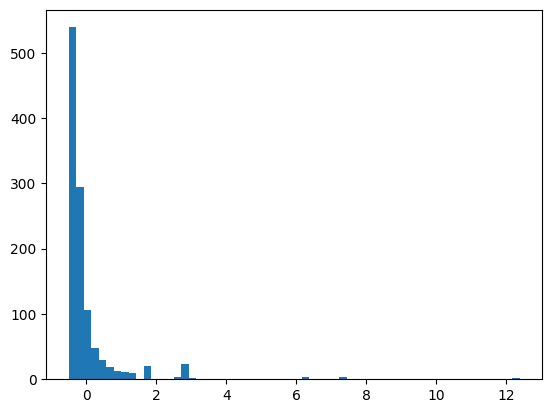

In [ ]:
print("Mean", subset['continuous']['parcel_sqm'].mean())
print("Median", subset['continuous']['parcel_sqm'].median())
print("Max", subset['continuous']['parcel_sqm'].max())
print("Min", subset['continuous']['parcel_sqm'].min())
#histogram
plt.hist(subset['continuous']['parcel_sqm'], bins=60)
plt.show()


In [ ]:
columns_to_standardize = [
    "housing_units_original",
    "total_value_original",
]

new_standardization_dict = {}

for column in columns_to_standardize:
    new_standardization_dict[column] = {
        "mean": new_data['continuous'][column].mean(),
        "std": new_data['continuous'][column].std(),
    }


In [ ]:
# these seem realistic

old_standardization_dict = ct_dataset_read.standardization_dictionary   

for key in new_standardization_dict:
    print(key, old_standardization_dict[key[:-len('_original')]])
    print(key, new_standardization_dict[key])


housing_units_original {'mean': 37.57720588235294, 'std': 91.84181610416991}
housing_units_original {'mean': tensor(31.1124), 'std': tensor(90.1668)}
total_value_original {'mean': 373244336.6862745, 'std': 444410879.6350971}
total_value_original {'mean': tensor(3.5076e+08), 'std': tensor(4.5121e+08)}


In [ ]:

pg_census_tracts_dataset = ZoningDataset(
    new_data['categorical'], new_data['continuous'], standardization_dictionary=new_standardization_dict
)


assert "parcel_sqm" in new_data['continuous'].keys()

pg_census_tracts_loader = DataLoader(pg_census_tracts_dataset, batch_size=len(pg_census_tracts_dataset), shuffle=True)

pg_census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

torch.save(pg_census_tracts_dataset, pg_census_tracts_data_path)